In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_ENABLE_ONEDNN_OPTS'] =  "0"



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

## Librerías
import seaborn as sns
import sys
import cv2 as cv2
import glob
from PIL import Image
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import gc
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
import os


from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

print(tf.__version__)

2024-08-31 20:43:09.112936: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-31 20:43:09.112968: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-31 20:43:09.116956: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-31 20:43:09.460057: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.14.0


In [2]:
## Uso de GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

2024-08-31 20:43:14.099614: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-31 20:43:14.177985: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-31 20:43:14.178148: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Datos

In [4]:
## function to load images
def load_binary_images(file_names):  
    image = np.load(file_names).astype(np.float32)
    image = np.expand_dims(image, axis=-1)
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.image.resize(image, [32,32])   
    ## binariazar
    image = tf.where(image > 0.5, 1.0, 0.0)  
    return image

def load_images(file_names):
    image = np.load(file_names).astype(np.float32)
    #expand_dims
    image = np.expand_dims(image, axis=-1)
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.image.resize(image, [32,32])/255.0    
      
    return image

def min_max_scaler(ruta,image):
    ## load images in the path
    images = glob.glob(ruta + '/*.npy')
    images = sorted(images)
    ## load images
    images = [load_images(image) for image in images]
    ## min max scaler of thei image using the max and min of all images
    images = np.array(images)
    max_value = np.max(images)
    min_value = np.min(images)
    image = tf.math.abs((image - min_value)/(max_value - min_value))
    return image   

## Function to get contours and features
def get_contours_and_features(binary_map):
    #https://docs.opencv.org/4.x/d3/d05/tutorial_py_table_of_contents_contours.html
    #binary_map = cv2.cvtColor(binary_map, cv2.COLOR_BGR2GRAY)
    contours, hierarchy = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours_features = []
    for contour in contours:
        error = 1e-5
        moments = cv2.moments(contour)
        cx = moments['m10'] / (moments['m00'] + error)
        cy = moments['m01'] / (moments['m00'] + error)
        center_of_mass = [cx, cy]
        x,y,w,h = cv2.boundingRect(contour)        
        rect_area = w*h
        features = {
            'bounding_box': (x,y,w,h),
            'area': cv2.contourArea(contour),
            'perimeter': cv2.arcLength(contour, True),       
            #'solidity': np.float32(cv2.contourArea(contour))/cv2.convexHull(contour),
            'equivalent_diameter': np.sqrt(4*cv2.contourArea(contour)/np.pi),            
            'moments': moments,
            'center_of_mass': center_of_mass,
            'contour': contour
        }
        contours_features.append(features)
        del features
    #plt.imshow(contours_map, cmap='gray')
    return contours_features

# function to get a determined property from a list of contours features (area by default)
def get_item(contour_features, key='area'):
    areas = []
    for contour_feature in contour_features:
        area =  contour_feature[key]
        areas.append(area)
    return areas

## function to get geometric_attributes
def get_geometric_atributes(binary_images):
    descriptors = []
    for binary_img in binary_images:
        ## Formato
        image = binary_img.numpy().astype(np.uint8)       
        
        ## Capturar contornos
        contour_features = get_contours_and_features(image)
        
        ## Calcular vector de áreas de poro (todos los poros)
        areas = get_item(contour_features, key='area')

        ## Calcular vector de perímetros de poro (todo los poros)
        pmtro = get_item(contour_features, key='perimeter')

        ## Calcular el diametro equivalente de los poros
        eq_diameter = get_item(contour_features, key='equivalent_diameter')           

      

        descriptor = [np.mean(areas), np.mean(pmtro),np.mean(eq_diameter)]
        
        descriptors.append(descriptor)
        
    
    return descriptors

## function to get the middle image route in the folder
def get_middle_image(folder_route):
    ## get list of images
    images = glob.glob(folder_route + '/*.npy')
    ## order images
    images = sorted(images)
    ## get index of middle image
    if len(images) == 0:
        indx = -1
        middle_image = 'empty'
    else:
        indx = int(np.floor(len(images)/2))
        middle_image = images[indx]   
    
    return middle_image

## annotations to get nodule_features
annotations_cvs_4R = pd.read_csv('/data/Datasets/Nodules_ISBI/meta_created_info_3d_4R.csv')
annotations_csv_3R = pd.read_csv('/data/Datasets/Nodules_ISBI/meta_created_info_3d_3R.csv')
annotations = pd.concat([annotations_cvs_4R, annotations_csv_3R])
## drop malignancy = 3
annotations = annotations[annotations['malignancy'] != 3]
annotations

,patient_id,nodule_no,folder,malignancy,is_cancer,calcification,lobulation,texture,spiculation,subtlety,margin,intercept,slope
0,1,0,LICD-0001_NI000,5,True,6,3,5,5,5,4,-1024.0,1.0
1,3,1,LICD-0003_NI001,5,True,6,2,4,3,5,3,-1024.0,1.0
2,3,2,LICD-0003_NI002,4,True,6,2,5,2,4,4,-1024.0,1.0
3,3,3,LICD-0003_NI003,4,True,6,1,5,1,4,5,-1024.0,1.0
4,4,0,LICD-0004_NI000,1,False,3,1,5,1,3,5,-1024.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,353,0,LICD-0353_NI000,1,False,3,1,5,1,5,5,-1024.0,1.0
27,354,0,LICD-0354_NI000,1,False,3,1,5,1,5,5,0.0,1.0
28,390,6,LICD-0390_NI006,1,False,3,1,5,1,4,5,-1024.0,1.0
29,390,7,LICD-0390_NI007,1,False,3,1,5,1,3,5,-1024.0,1.0


In [5]:
## ruta dataset
rutas_images_npy = glob.glob('/data/Datasets/Nodules_ISBI/images/*/*.npy')

## order list by folder
rutas_images_npy = sorted(rutas_images_npy)

## get list of folders
folders = [ruta.split('/')[-2] for ruta in rutas_images_npy]
folders = np.unique(folders)

## build dataframe
rutas_images = []
rutas_masks = []
areas = []
perimetros = []
diametros = []
calsifications = []
spiculations = []
lobulations = []
sphericities = []
textures = []
margins = []

## cancer or not
labels = []
    
for folder in folders:
    ruta = '/data/Datasets/Nodules_ISBI/images/' + folder
    ruta_masc = '/data/Datasets/Nodules_ISBI/masks/' + folder
    
    ## load middle image route
    image_route = get_middle_image(ruta)
    name_image = image_route.split('/')[-1]
    mask_route = ruta_masc + '/' + name_image       
    
    if image_route != 'empty':    
        ## get attributes
        image = load_images(image_route)
        ## min-max scaler
        image = min_max_scaler(ruta, image)
        ## binary image
        binary_image = load_binary_images(mask_route)   
        ## get features of the image            
        features = annotations[annotations['folder'] == folder]
        if features.shape[0] != 0:     
            ## append rutas
            geometric_attributes = get_geometric_atributes([binary_image])[0]
            rutas_images.append(image_route)
            rutas_masks.append(mask_route)
            
            ## append attributes
            areas.append(geometric_attributes[0])
            perimetros.append(geometric_attributes[1])
            diametros.append(geometric_attributes[2])     
              
            malignancy = features['malignancy'].values[0]
            calsification = features['calcification'].values[0]
            spiculation = features['spiculation'].values[0]
            lobulation = features['lobulation'].values[0]
            texture = features['texture'].values[0]
            label = features['is_cancer'].values[0]
            margin = features['margin'].values[0]
            
            ## append featuresprint(features)
            calsifications.append(calsification)
            spiculations.append(spiculation)
            lobulations.append(lobulation)
            textures.append(texture)
            labels.append(label)
            margins.append(margin)


## build dataframe
df = pd.DataFrame()
df['ruta'] = rutas_images
df['mask'] = rutas_masks
df['area'] = areas
df['perimetro'] = perimetros
df['diametro'] = diametros
df['calsification'] = calsifications
df['spiculation'] = spiculations
df['lobulation'] = lobulations
df['texture'] = textures
df['margin'] = margins
df['label'] = labels

df

2024-08-31 20:49:31.490685: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-31 20:49:31.494875: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-31 20:49:31.494997: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

,ruta,mask,area,perimetro,diametro,calsification,spiculation,lobulation,texture,margin,label
0,/data/Datasets/Nodules_ISBI/images/LICD-0001_N...,/data/Datasets/Nodules_ISBI/masks/LICD-0001_NI...,128.5,49.213203,12.791063,6,5,3,5,4,True
1,/data/Datasets/Nodules_ISBI/images/LICD-0003_N...,/data/Datasets/Nodules_ISBI/masks/LICD-0003_NI...,86.0,36.970562,10.464158,6,3,2,4,3,True
2,/data/Datasets/Nodules_ISBI/images/LICD-0003_N...,/data/Datasets/Nodules_ISBI/masks/LICD-0003_NI...,39.5,24.727922,7.091753,6,2,2,5,4,True
3,/data/Datasets/Nodules_ISBI/images/LICD-0003_N...,/data/Datasets/Nodules_ISBI/masks/LICD-0003_NI...,50.0,26.970562,7.978846,6,1,1,5,5,True
4,/data/Datasets/Nodules_ISBI/images/LICD-0004_N...,/data/Datasets/Nodules_ISBI/masks/LICD-0004_NI...,10.5,14.242641,3.656366,3,1,1,5,5,False
...,...,...,...,...,...,...,...,...,...,...,...
528,/data/Datasets/Nodules_ISBI/images/LICD-1007_N...,/data/Datasets/Nodules_ISBI/masks/LICD-1007_NI...,16.0,16.485281,4.513517,6,1,1,5,4,False
529,/data/Datasets/Nodules_ISBI/images/LICD-1011_N...,/data/Datasets/Nodules_ISBI/masks/LICD-1011_NI...,117.5,43.556349,12.231339,6,4,1,4,4,True
530,/data/Datasets/Nodules_ISBI/images/LICD-1011_N...,/data/Datasets/Nodules_ISBI/masks/LICD-1011_NI...,70.5,36.384776,9.474354,6,2,3,5,4,True
531,/data/Datasets/Nodules_ISBI/images/LICD-1011_N...,/data/Datasets/Nodules_ISBI/masks/LICD-1011_NI...,81.5,35.213203,10.186708,6,3,3,5,3,True


(32, 32, 1) (32, 32, 1) <class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


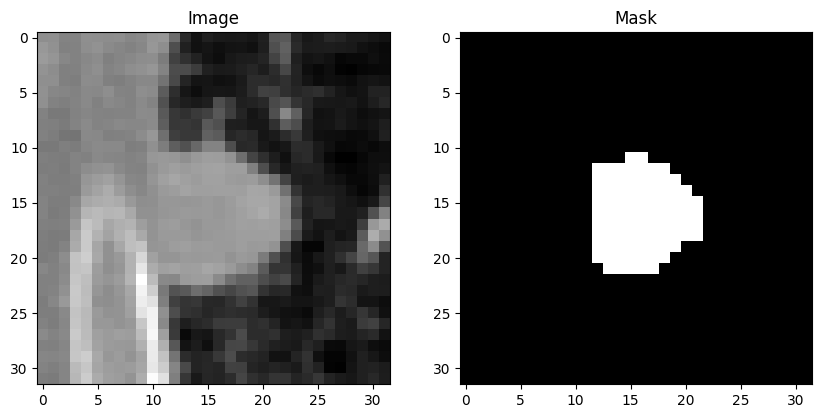

In [6]:
## plot a random image with mask
indx = np.random.randint(0, df.shape[0])
image = load_images(df['ruta'].values[indx])
mask = load_binary_images(df['mask'].values[indx])

print(np.shape(image), np.shape(mask),type(image), type(mask))

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.subplot(1,2,2)
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.show()

# Dataset

In [7]:
df_positive = df[df['label'] == 'True']
df_negative = df[df['label'] == 'False']

print('Positive shape: ', df_positive.shape)
print('Negative shape: ', df_negative.shape)

## seed 
np.random.seed(0)

## shuffle data
df_positive = df_positive.sample(frac=1)
df_negative = df_negative.sample(frac=1)

## sample 120 positive and 120 negative
pctg = 0.8
n_train_samples_positive = int(df_positive.shape[0]*pctg)
n_train_samples_negative = int(df_negative.shape[0]*pctg)

df_positive_train = df_positive.iloc[:n_train_samples_positive]
df_positive_test = df_positive.iloc[n_train_samples_positive:]

df_negative_train = df_negative.iloc[:n_train_samples_negative]
df_negative_test = df_negative.iloc[n_train_samples_negative:]

print('Positive train shape: ', df_positive_train.shape)
print('Positive test shape: ', df_positive_test.shape)
print('Negative train shape: ', df_negative_train.shape)
print('Negative test shape: ', df_negative_test.shape)

## concat dataframes
df_train = pd.concat([df_positive_train, df_negative_train])
df_test = pd.concat([df_positive_test, df_negative_test])

## re-shuffle data
df_train = df_train.sample(frac=1)
df_test = df_test.sample(frac=1)

## replace labels
df_train['label'] = df_train['label'].replace({'True': 1, 'False': 0})
df_test['label'] = df_test['label'].replace({'True': 1, 'False': 0})

print('Train shape: ', df_train.shape)
print('Test shape: ', df_test.shape)

Positive shape:  (359, 11)
Negative shape:  (174, 11)
Positive train shape:  (287, 11)
Positive test shape:  (72, 11)
Negative train shape:  (139, 11)
Negative test shape:  (35, 11)
Train shape:  (426, 11)
Test shape:  (107, 11)


In [11]:
## create dataset function 
def create_train_dataset(batch,df):
    images_routes = df['ruta'].to_numpy()
    labels = df['label'].to_numpy()
    features = df[['area', 'spiculation', 'lobulation', 'margin','texture']].to_numpy()
    
    
    ## Data augmentation
    def flip_left_image(image):
        ## flip left-right
        image = tf.image.random_flip_left_right(image)
        return image
    
    def rotate90_image(image):
        ## rotate 90 degrees
        image = tf.image.rot90(image)
        return image
    
    def rotate180_image(arg):
        ## rotate 180 degrees
        image = tf.image.rot90(arg, k=2)
        return image
    
    def flip_right_image(image):
        ## flip up-down
        image = tf.image.random_flip_up_down(image)
        return image

        
        
    
    images = []
    new_labels = []
    new_features = []
    for image_route, label, features in zip(images_routes, labels,features):
        image_original = load_images(image_route)
        image_left_flip = flip_left_image(image_original)
        image_right_flip = flip_right_image(image_original)
        image_rotate90 = rotate90_image(image_original)
        image_rotate180 = rotate180_image(image_original)
        images.append(image_original)
        images.append(image_left_flip)
        images.append(image_right_flip)
        images.append(image_rotate90)
        images.append(image_rotate180)
        new_labels.append(label)
        new_labels.append(label)
        new_labels.append(label)
        new_labels.append(label)
        new_labels.append(label)
        new_features.append(features)
        new_features.append(features)
        new_features.append(features)
        new_features.append(features)
        new_features.append(features)
        
        
    ## convert to tensor
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    labels = tf.convert_to_tensor(new_labels, dtype=tf.float32)
    features = tf.convert_to_tensor(new_features, dtype=tf.float32)    
    
    
    dataset = tf.data.Dataset.from_tensor_slices((images, features, labels))
    
    ## apply preprocess_image function
    dataset = dataset.map(lambda image, features, label: (image, features, label))
    
    dataset = dataset.shuffle(batch)
    
    dataset = dataset.batch(batch)
    
    return dataset


## create dataset function 
def create_test_dataset(batch,df):
    images_routes = df['ruta'].to_numpy()
    labels = df['label'].to_numpy()
    features = df[['area', 'spiculation', 'lobulation', 'margin','texture']].to_numpy()
    
    
    images = []
    for image_route in images_routes:
        image = load_images(image_route)
        images.append(image)
        
    ## convert to tensor
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    labels = tf.convert_to_tensor(labels, dtype=tf.float32)
    features = tf.convert_to_tensor(features, dtype=tf.float32)
       
    
    
    dataset = tf.data.Dataset.from_tensor_slices((images, features, labels))
    
    ## apply preprocess_image function
    dataset = dataset.map(lambda image, features, label: (image, features, label))
    
    dataset = dataset.shuffle(100)
    
    dataset = dataset.batch(batch)
    
    return dataset

train_dataset = create_train_dataset(8, df_train)
test_dataset = create_test_dataset(8, df_test)

i = 0
for image, features, label in train_dataset:
   i += np.shape(image)[0]

print('Train dataset size: ', i)
    

Train dataset size:  2130


In [22]:
## Dataset de prueba
X_test = []
y_test = []

for image, features, label in test_dataset:
    X_test.extend(image.numpy())
    y_test.extend(label.numpy())
    
    
X_train = []
y_train = []

for image, features, label in train_dataset:
    X_train.extend(image.numpy())
    y_train.extend(label.numpy())
    
print('Test: train->',np.shape(X_test),' test ->',np.shape(y_test))
print('Train: train->',np.shape(X_train),' test ->',np.shape(y_train))

Test: train-> (107, 32, 32, 1)  test -> (107,)
Train: train-> (2130, 32, 32, 1)  test -> (2130,)


# Modelos

In [17]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [19]:
## cargar todos los encoder y decoder para cada uno de los b-vae entrenados
# b = 0.01
encoder_001 = keras.models.load_model('BetaVAE_Models/betha_0.01/GVAE_8_encoder_betha_0.01_.h5',custom_objects={'Sampling':Sampling})
decoder_001 = keras.models.load_model('BetaVAE_Models/betha_0.01/GVAE_8_decoder_betha_0.01_.h5',custom_objects={'Sampling':Sampling})

# b = 0.1
encoder_01 = keras.models.load_model('BetaVAE_Models/betha_0.1/GVAE_8_encoder_betha_0.1_.h5',custom_objects={'Sampling':Sampling})
decoder_01 = keras.models.load_model('BetaVAE_Models/betha_0.1/GVAE_8_decoder_betha_0.1_.h5',custom_objects={'Sampling':Sampling})

# b = 1
encoder_1 = keras.models.load_model('BetaVAE_Models/betha_1/GVAE_8_encoder_betha_1_.h5',custom_objects={'Sampling':Sampling})
decoder_1 = keras.models.load_model('BetaVAE_Models/betha_1/GVAE_8_decoder_betha_1_.h5',custom_objects={'Sampling':Sampling})

# b = 10
encoder_10 = keras.models.load_model('BetaVAE_Models/betha_10/GVAE_8_encoder_betha_10_.h5',custom_objects={'Sampling':Sampling})
decoder_10 = keras.models.load_model('BetaVAE_Models/betha_10/GVAE_8_decoder_betha_10_.h5',custom_objects={'Sampling':Sampling})

# b = 100
encoder_100 = keras.models.load_model('BetaVAE_Models/betha_100/GVAE_8_encoder_betha_100_.h5',custom_objects={'Sampling':Sampling})
decoder_100 = keras.models.load_model('BetaVAE_Models/betha_100/GVAE_8_decoder_betha_100_.h5',custom_objects={'Sampling':Sampling})

In [27]:
# 1. Cargar los embebidos
x_train = X_train.copy()
x_test = X_test.copy()

x_train = np.array(x_train)
x_test = np.array(x_test)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

## b = 0.01
embeddings_001 = encoder_001.predict(x_train)
embeddings_001_test = encoder_001.predict(x_test)

## b = 0.1
embeddings_01 = encoder_01.predict(x_train)
embeddings_01_test = encoder_01.predict(x_test)

## b = 1
embeddings_1 = encoder_1.predict(x_train)
embeddings_1_test = encoder_1.predict(x_test)

## b = 10
embeddings_10 = encoder_10.predict(x_train)
embeddings_10_test = encoder_10.predict(x_test)

## b = 100
embeddings_100 = encoder_100.predict(x_train)
embeddings_100_test = encoder_100.predict(x_test)

67/67 [==============================] - 0s 958us/step


4/4 [==============================] - 0s 1ms/step


In [28]:
## 2. Reconstruir las imágenes
## b = 0.01
reconstructed_001 = decoder_001.predict(embeddings_001[2])
reconstructed_001_test = decoder_001.predict(embeddings_001_test[2])

## b = 0.1
reconstructed_01 = decoder_01.predict(embeddings_01[2])
reconstructed_01_test = decoder_01.predict(embeddings_01_test[2])

## b = 1
reconstructed_1 = decoder_1.predict(embeddings_1[2])
reconstructed_1_test = decoder_1.predict(embeddings_1_test[2])

## b = 10
reconstructed_10 = decoder_10.predict(embeddings_10[2])
reconstructed_10_test = decoder_10.predict(embeddings_10_test[2])

## b = 100
reconstructed_100 = decoder_100.predict(embeddings_100[2])
reconstructed_100_test = decoder_100.predict(embeddings_100_test[2])

4/4 [==============================] - 0s 1ms/step


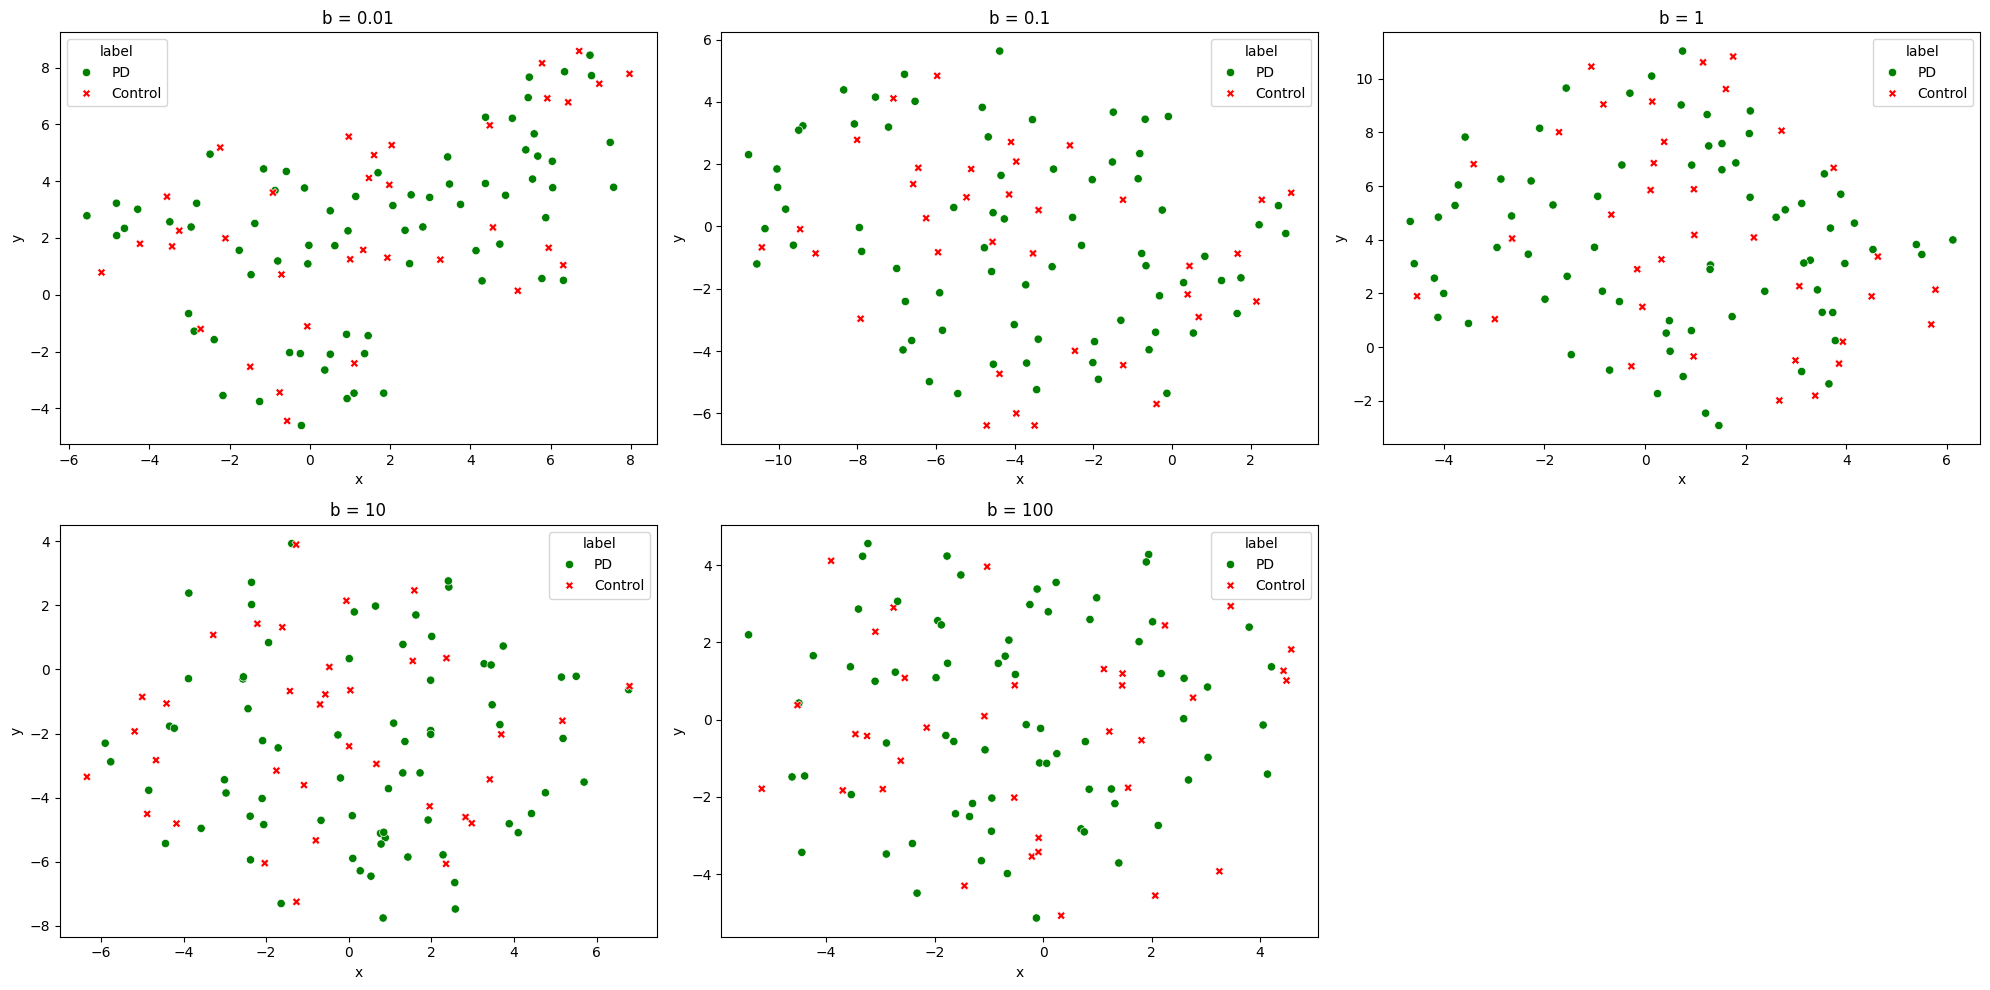

In [29]:
## 2. Acomodar las etiquetas
labels_text_test = pd.DataFrame(y_test).replace({0.0: "Control", 1.0: "PD"})
labels_text_test.shape

## 3. T-sne para cada uno de los embebidos de test
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
# b = 0.01
tsne_001 = tsne.fit_transform(embeddings_001_test[2])
# b = 0.1
tsne_01 = tsne.fit_transform(embeddings_01_test[2])
# b = 1
tsne_1 = tsne.fit_transform(embeddings_1_test[2])
# b = 10
tsne_10 = tsne.fit_transform(embeddings_10_test[2])
# b = 100
tsne_100 = tsne.fit_transform(embeddings_100_test[2])

## 4. Graficar los resultados
plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
tsne_data = pd.DataFrame()
tsne_data['x'] = tsne_001[:,0]
tsne_data['y'] = tsne_001[:,1]
tsne_data['label'] = labels_text_test
sns.scatterplot(x=tsne_data.x,y=tsne_data.y,hue='label',data=tsne_data,style='label',
            sizes=(60, 100), alpha=1, palette={"Control": "red", "PD": "green"},
                legend=True)
plt.title('b = 0.01')

plt.subplot(2,3,2)
tsne_data = pd.DataFrame()
tsne_data['x'] = tsne_01[:,0]
tsne_data['y'] = tsne_01[:,1]
tsne_data['label'] = labels_text_test
sns.scatterplot(x=tsne_data.x,y=tsne_data.y,hue='label',data=tsne_data,style='label',
            sizes=(60, 100), alpha=1, palette={"Control": "red", "PD": "green"},
                legend=True)
plt.title('b = 0.1')

plt.subplot(2,3,3)
tsne_data = pd.DataFrame()
tsne_data['x'] = tsne_1[:,0]
tsne_data['y'] = tsne_1[:,1]
tsne_data['label'] = labels_text_test
sns.scatterplot(x=tsne_data.x,y=tsne_data.y,hue='label',data=tsne_data,style='label',
            sizes=(60, 100), alpha=1, palette={"Control": "red", "PD": "green"},
                legend=True)
plt.title('b = 1')


plt.subplot(2,3,4)
tsne_data = pd.DataFrame()
tsne_data['x'] = tsne_10[:,0]
tsne_data['y'] = tsne_10[:,1]
tsne_data['label'] = labels_text_test
sns.scatterplot(x=tsne_data.x,y=tsne_data.y,hue='label',data=tsne_data,style='label',
            sizes=(60, 100), alpha=1, palette={"Control": "red", "PD": "green"},
                legend=True)
plt.title('b = 10')

plt.subplot(2,3,5)
tsne_data = pd.DataFrame()
tsne_data['x'] = tsne_100[:,0]
tsne_data['y'] = tsne_100[:,1]
tsne_data['label'] = labels_text_test
sns.scatterplot(x=tsne_data.x,y=tsne_data.y,hue='label',data=tsne_data,style='label',
            sizes=(60, 100), alpha=1, palette={"Control": "red", "PD": "green"},
                legend=True)
plt.title('b = 100')


plt.tight_layout()

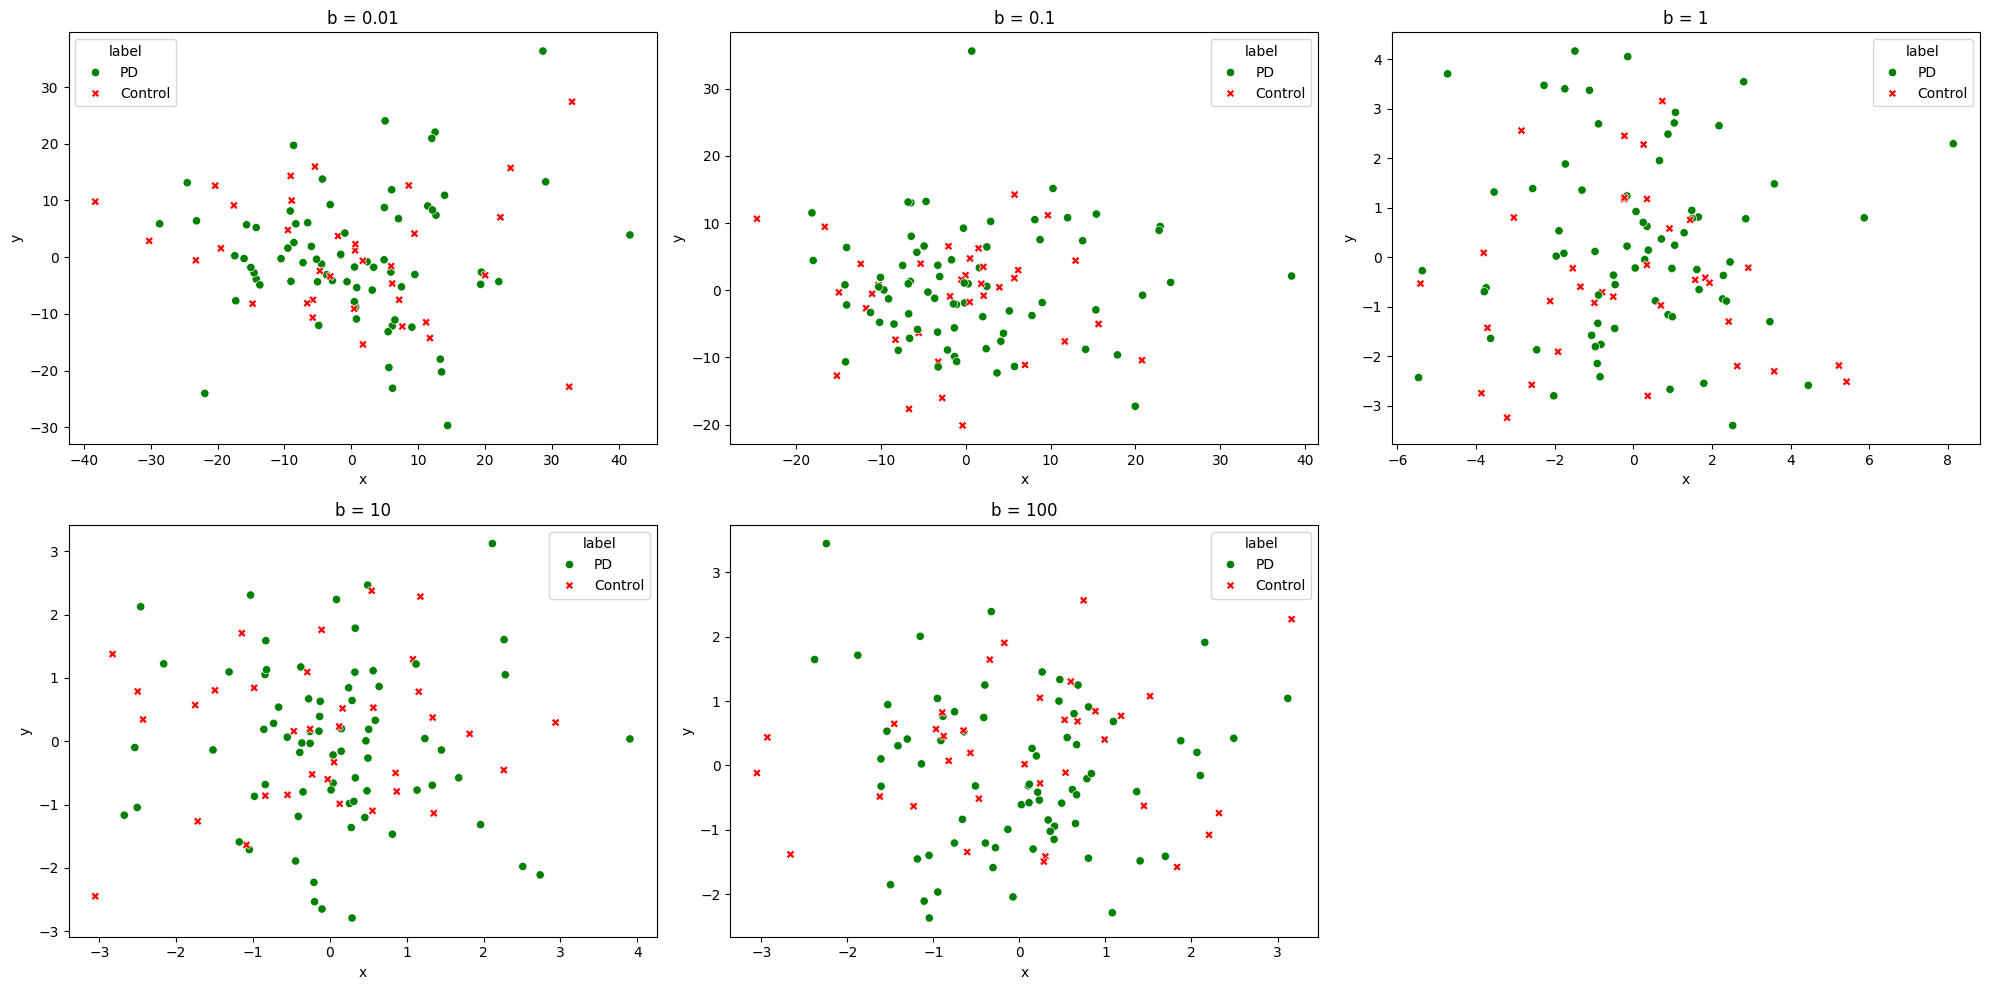

In [30]:
## 2. Acomodar las etiquetas
labels_text_test = pd.DataFrame(y_test).replace({0.0: "Control", 1.0: "PD"})
labels_text_test.shape

## 3. T-sne para cada uno de los embebidos de test
pca = PCA(n_components=2, random_state=0)
# b = 0.01
pca_001 = pca.fit_transform(embeddings_001_test[2])
# b = 0.1
pca_01 = pca.fit_transform(embeddings_01_test[2])
# b = 1
pca_1 = pca.fit_transform(embeddings_1_test[2])
# b = 10
pca_10 = pca.fit_transform(embeddings_10_test[2])
# b = 100
pca_100 = pca.fit_transform(embeddings_100_test[2])

## 4. Graficar los resultados
plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
pca_data = pd.DataFrame()
pca_data['x'] = pca_001[:,0]
pca_data['y'] = pca_001[:,1]
pca_data['label'] = labels_text_test
sns.scatterplot(x=pca_data.x,y=pca_data.y,hue='label',data=pca_data,style='label',
            sizes=(60, 100), alpha=1, palette={"Control": "red", "PD": "green"},
                legend=True)
plt.title('b = 0.01')

plt.subplot(2,3,2)
pca_data = pd.DataFrame()
pca_data['x'] = pca_01[:,0]
pca_data['y'] = pca_01[:,1]
pca_data['label'] = labels_text_test
sns.scatterplot(x=pca_data.x,y=pca_data.y,hue='label',data=pca_data,style='label',
            sizes=(60, 100), alpha=1, palette={"Control": "red", "PD": "green"},
                legend=True)
plt.title('b = 0.1')

plt.subplot(2,3,3)
pca_data = pd.DataFrame()
pca_data['x'] = pca_1[:,0]
pca_data['y'] = pca_1[:,1]
pca_data['label'] = labels_text_test
sns.scatterplot(x=pca_data.x,y=pca_data.y,hue='label',data=pca_data,style='label',
            sizes=(60, 100), alpha=1, palette={"Control": "red", "PD": "green"},
                legend=True)
plt.title('b = 1')

plt.subplot(2,3,4)
pca_data = pd.DataFrame()
pca_data['x'] = pca_10[:,0]
pca_data['y'] = pca_10[:,1]
pca_data['label'] = labels_text_test
sns.scatterplot(x=pca_data.x,y=pca_data.y,hue='label',data=pca_data,style='label',
            sizes=(60, 100), alpha=1, palette={"Control": "red", "PD": "green"},
                legend=True)
plt.title('b = 10')

plt.subplot(2,3,5)
pca_data = pd.DataFrame()
pca_data['x'] = pca_100[:,0]
pca_data['y'] = pca_100[:,1]
pca_data['label'] = labels_text_test
sns.scatterplot(x=pca_data.x,y=pca_data.y,hue='label',data=pca_data,style='label',
            sizes=(60, 100), alpha=1, palette={"Control": "red", "PD": "green"},
                legend=True)
plt.title('b = 100')


plt.tight_layout()

# Clasificación de embebidos

In [31]:
## clasificación de los embebidos
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## prepare labels for classification 
# train int to one hot-encoding
y_train_labels = np.array(y_train)
y_train_labels = y_train_labels.astype('int')


# test str to int to one hot-encoding
y_test_labels = np.array(y_test)
y_test_labels = y_test_labels.astype('int')

clf = SVC(kernel='linear')

## b = 0.01
clf_001 = clf.fit(embeddings_001[2], y_train_labels)
y_pred_001 = clf_001.predict(embeddings_001_test[2])


report_001 = classification_report(y_test_labels, y_pred_001)

## b = 0.1

clf_01 = clf.fit(embeddings_01[2], y_train_labels)
y_pred_01 = clf_01.predict(embeddings_01_test[2])

report_01 = classification_report(y_test_labels, y_pred_01)

## b = 1
clf_1 = clf.fit(embeddings_1[2], y_train_labels)
y_pred_1 = clf_1.predict(embeddings_1_test[2])

report_1 = classification_report(y_test_labels, y_pred_1)

## b = 10

clf_10 = clf.fit(embeddings_10[2], y_train_labels)
y_pred_10 = clf_10.predict(embeddings_10_test[2])

report_10 = classification_report(y_test_labels, y_pred_10)

## b = 100

clf_100 = clf.fit(embeddings_100[2], y_train_labels)
y_pred_100 = clf_100.predict(embeddings_100_test[2])

report_100 = classification_report(y_test_labels, y_pred_100)



print('b = 0.01')
print(report_001)

print('b = 0.1')
print(report_01)

print('b = 1')
print(report_1)

print('b = 10')
print(report_10)

print('b = 100')
print(report_100)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classif

b = 0.01
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.67      1.00      0.80        72

    accuracy                           0.67       107
   macro avg       0.34      0.50      0.40       107
weighted avg       0.45      0.67      0.54       107

b = 0.1
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.67      1.00      0.80        72

    accuracy                           0.67       107
   macro avg       0.34      0.50      0.40       107
weighted avg       0.45      0.67      0.54       107

b = 1
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.67      1.00      0.80        72

    accuracy                           0.67       107
   macro avg       0.34      0.50      0.40       107
weighted avg       0.45      0.67      0.54       1

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
## clasificación de los embebidos Random Forest
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## prepare labels for classification 
# train int to one hot-encoding
y_train_labels = np.array(y_train)
y_train_labels = y_train_labels.astype('int')


# test str to int to one hot-encoding
y_test_labels = np.array(y_test)
y_test_labels = y_test_labels.astype('int')

clf = RFC(n_estimators=100, max_depth=2, random_state=0)

## b = 0.1
clf_001 = clf.fit(embeddings_001[2], y_train_labels)
y_pred_001 = clf_001.predict(embeddings_001_test[2])


report_001 = classification_report(y_test_labels, y_pred_001)

## b = 0.5

clf_01 = clf.fit(embeddings_01[2], y_train_labels)
y_pred_01 = clf_01.predict(embeddings_01_test[2])

report_01 = classification_report(y_test_labels, y_pred_01)

## b = 1
clf_1 = clf.fit(embeddings_1[2], y_train_labels)
y_pred_1 = clf_1.predict(embeddings_1_test[2])

report_1 = classification_report(y_test_labels, y_pred_1)

## b = 10

clf_10 = clf.fit(embeddings_10[2], y_train_labels)
y_pred_10 = clf_10.predict(embeddings_10_test[2])

report_10 = classification_report(y_test_labels, y_pred_10)

## b = 100

clf_100 = clf.fit(embeddings_100[2], y_train_labels)
y_pred_100 = clf_100.predict(embeddings_100_test[2])

report_100 = classification_report(y_test_labels, y_pred_100)



print('b = 0.1')
print(report_01)

print('b = 0.1')
print(report_01)

print('b = 1')
print(report_1)

print('b = 10')
print(report_10)

print('b = 100')
print(report_100)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classif

b = 0.1
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.67      1.00      0.80        72

    accuracy                           0.67       107
   macro avg       0.34      0.50      0.40       107
weighted avg       0.45      0.67      0.54       107

b = 0.1
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.67      1.00      0.80        72

    accuracy                           0.67       107
   macro avg       0.34      0.50      0.40       107
weighted avg       0.45      0.67      0.54       107

b = 1
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.67      0.99      0.80        72

    accuracy                           0.66       107
   macro avg       0.33      0.49      0.40       107
weighted avg       0.45      0.66      0.54       10

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classif

In [33]:
## clasificación de los embebidos decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## prepare labels for classification 
# train int to one hot-encoding
y_train_labels = np.array(y_train)
y_train_labels = y_train_labels.astype('int')


# test str to int to one hot-encoding
y_test_labels = np.array(y_test)
y_test_labels = y_test_labels.astype('int')

clf = DecisionTreeClassifier(max_depth=3,random_state=0)

## b = 0.01

clf_001 = clf.fit(embeddings_001[2], y_train_labels)
y_pred_001 = clf_001.predict(embeddings_001_test[2])

report_001 = classification_report(y_test_labels, y_pred_001)

## b = 0.1
clf_01 = clf.fit(embeddings_01[2], y_train_labels)
y_pred_01 = clf_01.predict(embeddings_01_test[2])


report_01 = classification_report(y_test_labels, y_pred_01)

## b = 1
clf_1 = clf.fit(embeddings_1[2], y_train_labels)
y_pred_1 = clf_1.predict(embeddings_1_test[2])

report_1 = classification_report(y_test_labels, y_pred_1)

## b = 10

clf_10 = clf.fit(embeddings_10[2], y_train_labels)
y_pred_10 = clf_10.predict(embeddings_10_test[2])

report_10 = classification_report(y_test_labels, y_pred_10)

## b = 100

clf_100 = clf.fit(embeddings_100[2], y_train_labels)
y_pred_100 = clf_100.predict(embeddings_100_test[2])

report_100 = classification_report(y_test_labels, y_pred_100)



print('b = 0.01')
print(report_001)

print('b = 0.1')
print(report_01)

print('b = 1')
print(report_1)

print('b = 10')
print(report_10)

print('b = 100')
print(report_100)

b = 0.01
              precision    recall  f1-score   support

           0       0.62      0.14      0.23        35
           1       0.70      0.96      0.81        72

    accuracy                           0.69       107
   macro avg       0.66      0.55      0.52       107
weighted avg       0.67      0.69      0.62       107

b = 0.1
              precision    recall  f1-score   support

           0       0.43      0.09      0.14        35
           1       0.68      0.94      0.79        72

    accuracy                           0.66       107
   macro avg       0.55      0.52      0.47       107
weighted avg       0.60      0.66      0.58       107

b = 1
              precision    recall  f1-score   support

           0       0.60      0.09      0.15        35
           1       0.69      0.97      0.80        72

    accuracy                           0.68       107
   macro avg       0.64      0.53      0.48       107
weighted avg       0.66      0.68      0.59       1

In [34]:
## KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## prepare labels for classification 
# train int to one hot-encoding
y_train_labels = np.array(y_train)
y_train_labels = y_train_labels.astype('int')


# test str to int to one hot-encoding
y_test_labels = np.array(y_test)
y_test_labels = y_test_labels.astype('int')

clf = KNeighborsClassifier()

## b = 0.01

clf_001 = clf.fit(embeddings_001[2], y_train_labels)
y_pred_001 = clf_001.predict(embeddings_001_test[2])

report_001 = classification_report(y_test_labels, y_pred_001)

## b = 0.1
clf_01 = clf.fit(embeddings_01[2], y_train_labels)
y_pred_01 = clf_01.predict(embeddings_01_test[2])


report_01 = classification_report(y_test_labels, y_pred_01)

## b = 1
clf_1 = clf.fit(embeddings_1[2], y_train_labels)
y_pred_1 = clf_1.predict(embeddings_1_test[2])

report_1 = classification_report(y_test_labels, y_pred_1)

## b = 10

clf_10 = clf.fit(embeddings_10[2], y_train_labels)
y_pred_10 = clf_10.predict(embeddings_10_test[2])

report_10 = classification_report(y_test_labels, y_pred_10)

## b = 100

clf_100 = clf.fit(embeddings_100[2], y_train_labels)
y_pred_100 = clf_100.predict(embeddings_100_test[2])

report_100 = classification_report(y_test_labels, y_pred_100)

print('b = 0.01')
print(report_001)

print('b = 0.1')
print(report_01)

print('b = 1')
print(report_1)

print('b = 10')
print(report_10)

print('b = 100')
print(report_100)

b = 0.01
              precision    recall  f1-score   support

           0       0.27      0.17      0.21        35
           1       0.66      0.78      0.71        72

    accuracy                           0.58       107
   macro avg       0.47      0.47      0.46       107
weighted avg       0.53      0.58      0.55       107

b = 0.1
              precision    recall  f1-score   support

           0       0.22      0.11      0.15        35
           1       0.65      0.81      0.72        72

    accuracy                           0.58       107
   macro avg       0.44      0.46      0.44       107
weighted avg       0.51      0.58      0.53       107

b = 1
              precision    recall  f1-score   support

           0       0.35      0.20      0.25        35
           1       0.68      0.82      0.74        72

    accuracy                           0.62       107
   macro avg       0.51      0.51      0.50       107
weighted avg       0.57      0.62      0.58       1